[link text](https://)# CS236
Ryan Li, Lin Qiu

**Adapted from [Tune-A-Video: One-Shot Tuning of Image Diffusion Models for Text-to-Video Generation](https://arxiv.org/abs/2212.11565)**

**View Our Poster: https://drive.google.com/file/d/1tE2xZyqhXLJHhP7GW57fMejEUTpkOWAp/view?usp=sharing**

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install xformers==0.0.22.post4 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.4/211.4 MB 5.5 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla V100-SXM2-16GB, 16384 MiB, 16150 MiB


In [ ]:
#@title Install requirements

# !git clone https://github.com/showlab/Tune-A-Video.git/content/Tune-A-Video
%cd '/content/drive/Shareddrives/CS236/final_project/main'
# %pip install -r requirements.txt
%pip install -q -U --pre triton
%pip install typing-extensions==4.5.0 kaleido
%pip install -q diffusers[torch]==0.11.1 transformers==4.26.0 bitsandbytes==0.35.4\
decord accelerate omegaconf einops ftfy gradio imageio-ffmpeg xformers

/content/drive/Shareddrives/CS236/final_project/main
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Download pretrained model

#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown If model should be download from a remote repo. Untick it if the model is loaded from a local path.
download_pretrained_model = True #@param {type:"boolean"}
if download_pretrained_model:
    !git lfs install
    !git clone https://huggingface.co/$MODEL_NAME checkpoints/$MODEL_NAME
    MODEL_NAME = f"./checkpoints/{MODEL_NAME}"
print(f"[*] MODEL_NAME={MODEL_NAME}")

Git LFS initialized.
fatal: destination path 'checkpoints/CompVis/stable-diffusion-v1-4' already exists and is not an empty directory.
[*] MODEL_NAME=./checkpoints/CompVis/stable-diffusion-v1-4


## Usage


### Training


In [ ]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "outputs/fewshot/animal_walking" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/Shareddrives/CS236/final_project/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[*] Weights will be saved at /content/drive/Shareddrives/CS236/final_project/outputs/fewshot/animal_walking


In [ ]:
#@markdown Upload your video by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to `data` folder.

import os
from google.colab import files
import shutil

upload = False

if upload:
  uploaded = files.upload()
  for filename in uploaded.keys():
      dst_path = os.path.join("data", filename)
      shutil.move(filename, dst_path)

In [ ]:
import cv2
import os


def generate_video_from_frames(input_folder, output_path, output_fps):
    frame_files = sorted(os.listdir(input_folder))
    frame_path = os.path.join(input_folder, frame_files[0])
    frame = cv2.imread(frame_path)
    frame_height, frame_width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Specify the video codec (e.g., "mp4v", "XVID")

    # Create a VideoWriter object
    video = cv2.VideoWriter(output_path, fourcc, output_fps, (frame_width, frame_height))

    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)

        # Write the frame to the video
        video.write(frame)

    # Release the VideoWriter
    video.release()

    print("Video generation completed.")


# Example usage
input_folder = "DAVIS/JPEGImages/480p/rhino"  #@param {type:"string"}
output_path = "data/fewshot/rhino.mp4"  #@param {type:"string"}
output_fps = 24  # Specify the desired frames per second of the output video

generate_video_from_frames(input_folder, output_path, output_fps)

Video generation completed.


In [ ]:
#@markdown Train config
import os
from omegaconf import OmegaConf

CONFIG_NAME = "configs/animal_walking.yaml" #@param {type:"string"}

# train_video_path = "data/mbike-trick.mp4" #@param {type:"string"}
# train_prompt = "A young man in white shirt is riding motorcycle" #@param {type:"string"}

train_video_dir = "training_videos/animal_walking" #@param {type:"string"}
train_videos = os.listdir(train_video_dir)
print(train_videos)

train_prompts = [train_video.split('.')[0].replace("_", " ") for train_video in train_videos]
# train_prompts = ["lion walking"] * len(train_videos)
print(train_prompts)

train_video_paths = [os.path.join(train_video_dir, train_video) for train_video in train_videos]


# train_video_paths = [
#     "data/bear.mp4",
#     # "data/fewshot/move_left/car-shadow.mp4",
#     # "data/fewshot/move_left/classic-car.mp4",
#     "data/fewshot/move_left/rhino.mp4",
# ]

# train_prompts = [
#     "a bear walking down a rocky hillside",
#     # "a car driving left on a road",
#     # "an old-fashioned car driving left on a crowded road",
#     "a rhino slowly strolling left on a rocky road"
# ]


video_length = 16 #@param {type:"number"}
width = 512 #@param {type:"number"}
height = 320 #@param {type:"number"}
learning_rate = 3e-5 #@param {type:"number"}
train_steps = 16000 #@param {type:"number"}
config = {
  "pretrained_model_path": MODEL_NAME,
  "output_dir": OUTPUT_DIR,
  "train_data": {
    "video_paths": train_video_paths,
    "prompts": train_prompts,
    # "video_path": "data/bear.mp4",
    # "prompt": "a bear walking down a rocky hillside",
    "n_sample_frames": video_length,
    "width": width,
    "height": height,
    "sample_start_idx": 0,
    "sample_frame_rate": 2,
  },
  "validation_data": {
    "prompts": [
      "mickey mouse is skiing on the snow",
      "spider man is skiing on the beach, cartoon style",
      "wonder woman, wearing a cowboy hat, is skiing",
      "a man, wearing pink clothes, is skiing at sunset",
    ],
    "video_length": video_length,
    "width": width,
    "height": height,
    "num_inference_steps": 20,
    "guidance_scale": 12.5,
    "use_inv_latent": True,
    "num_inv_steps": 50,
  },
  "learning_rate": learning_rate,
  "lr_scheduler": "linear",
  "lr_warmup_steps": 300,
  "train_batch_size": 1,
  "max_train_steps": train_steps,
  "checkpointing_steps": 500,
  # "use_first_frame_conditioning": True,
  "resume_from_checkpoint": "/content/drive/Shareddrives/CS236/final_project/outputs/fewshot/animal_walking/checkpoint-16000",
  "validation_steps": 10000,
  "trainable_modules": [
    "attn1.to_q",
    "attn1.memory_update_layer",
    "attn2.to_q",
    "attn_temp",
  ],
  "seed": 33,
  "mixed_precision": "fp16",
  "use_8bit_adam": False,
  "gradient_checkpointing": True,
  "enable_xformers_memory_efficient_attention": True,
}

OmegaConf.save(config, CONFIG_NAME)

['bear_walking_in_river.mp4', 'rhino_walking_on_grass.mp4', 'polar_bear_walking_on_snow.mp4', 'tiger_walking_in_river.mp4', 'tiger_walking_in_zoo.mp4', 'elephant_walking_on_grassy_land.mp4', 'elephant_walking_slowly_on_grassland.mp4', 'elephant_walking_on_grassland_with_mountain_in_background.mp4', 'bear_walking_through_grass_beside_a_lake.mp4', 'bear_walking_in_front_of_bushes.mp4', 'elephant_walking_in_tall_grass.mp4', 'lion_walking_towards_another_lion.mp4', 'lion_walking_in_tall_grass.mp4', 'lion_walking_on_grassland.mp4', 'lion_walking_on_dirt.mp4', 'rhino_walking_in_tall_grass.mp4']
['bear walking in river', 'rhino walking on grass', 'polar bear walking on snow', 'tiger walking in river', 'tiger walking in zoo', 'elephant walking on grassy land', 'elephant walking slowly on grassland', 'elephant walking on grassland with mountain in background', 'bear walking through grass beside a lake', 'bear walking in front of bushes', 'elephant walking in tall grass', 'lion walking towards a

In [ ]:
print(CONFIG_NAME)

!accelerate launch train_cs236.py --config=$CONFIG_NAME


configs/animal_walking.yaml
2023-12-11 02:10:11.722957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 02:10:11.723045: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 02:10:11.727410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 02:10:11.932899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 02:

### Inference

In [ ]:
import torch
from torch import autocast
from diffusers import AutoencoderKL, DDIMScheduler
from cs236.pipelines.pipeline_cs236 import CS236Pipeline
from cs236.models.unet import UNet3DConditionModel
from cs236.util import save_videos_grid, ddim_inversion


unet = UNet3DConditionModel.from_pretrained(OUTPUT_DIR, subfolder='unet', torch_dtype=torch.float16).to('cuda')
vae = AutoencoderKL.from_pretrained(OUTPUT_DIR, subfolder="vae", torch_dtype=torch.float16).to('cuda')
vae.requires_grad_(False)
scheduler = DDIMScheduler.from_pretrained(MODEL_NAME, subfolder='scheduler', torch_dtype=torch.float16)
pipe = CS236Pipeline.from_pretrained(MODEL_NAME, unet=unet, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_vae_slicing()

g_cuda = None

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1234 #@param {type:"number"}
g_cuda.manual_seed(seed)

In [ ]:
import cv2

first_image = 'lion_walking_on_street.jpeg' #@param {type:"string"}
img_path = f'/content/drive/Shareddrives/CS236/final_project/main/first_frames/{first_image}'

image = cv2.imread(img_path)
image = cv2.resize(image, (512, 320))[:, :, ::-1]
first_frame_latents = torch.Tensor(image.copy()).to('cuda').type(torch.float16).permute(2, 0, 1).repeat(1, 1, 1, 1)
first_frame_latents = first_frame_latents / 127.5 - 1.0
first_frame_latents = vae.encode(first_frame_latents).latent_dist.sample() * 0.18215
print(first_frame_latents.shape)
first_frame_latents = first_frame_latents.repeat(1, 1, 1, 1, 1).permute(1, 2, 0, 3, 4).type(torch.float16)
print(first_frame_latents.shape)

scheduler.set_timesteps(50, device='cuda')

first_frame_latents = ddim_inversion(
                  pipe, scheduler, video_latent=first_frame_latents,
                  num_inv_steps=50, prompt="")[-1].to(torch.float16)
print(first_frame_latents.shape)



torch.Size([1, 4, 40, 64])
torch.Size([1, 4, 1, 40, 64])


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]

torch.Size([1, 4, 1, 40, 64])


/content/drive/Shareddrives/CS236/final_project/outputs/fewshot/animal_walking
starting pipeline...


  0%|          | 0/10 [00:00<?, ?it/s]

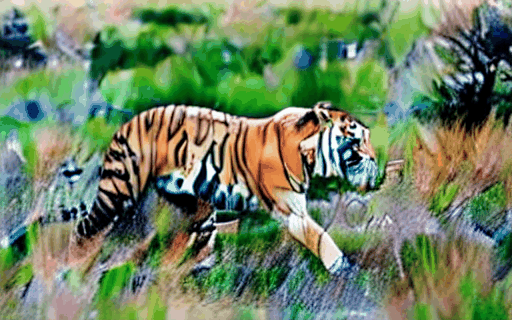

In [ ]:
# @markdown Run for generating videos.

prompt = "tiger walking in tall grass" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
use_inv_latent = False #@param {type:"boolean"}
use_first_frame_conditioning = True #@param {type:"boolean"}
inv_latent_path = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 10 #@param {type:"number"}
video_length = 8 #@param {type:"number"}
height = 320 #@param {type:"number"}
width = 512 #@param {type:"number"}

ddim_inv_latent = None
print(OUTPUT_DIR)
if use_inv_latent and inv_latent_path == "":
    from natsort import natsorted
    from glob import glob
    import os
    inv_latent_path = natsorted(glob(f"{OUTPUT_DIR}/inv_latents/*"))[-1]
    ddim_inv_latent = torch.load(inv_latent_path).to(torch.float16)
    print(f"DDIM inversion latent loaded from {inv_latent_path}")

with autocast("cuda"), torch.inference_mode():
    videos = pipe(
        prompt,
        latents=None,
        # first_frame_latents=first_frame_latents[:, :, :1, :, :],
        # use_first_frame_conditioning=use_first_frame_conditioning,
        video_length=video_length,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_videos_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).videos

save_dir = "./results_fewshot/animal_walking" #@param {type:"string"}
save_path = f"{save_dir}/{prompt}-10-16000-rand.gif"
save_videos_grid(videos, save_path)

# display
from IPython.display import Image, display
display(Image(filename=save_path))

In [ ]:
# #@markdown Free runtime memory
exit()

In [ ]:
unet = None
pipe = None
vae = None